Eğitim veri seti boyutu: (16478389, 9)
Test veri seti boyutu: (2109736, 9)
------------------------------


Modeller Eğitiliyor:   0%|                                                                       | 0/2 [00:00<?, ?it/s]


--- BR Modeli İşleniyor ---


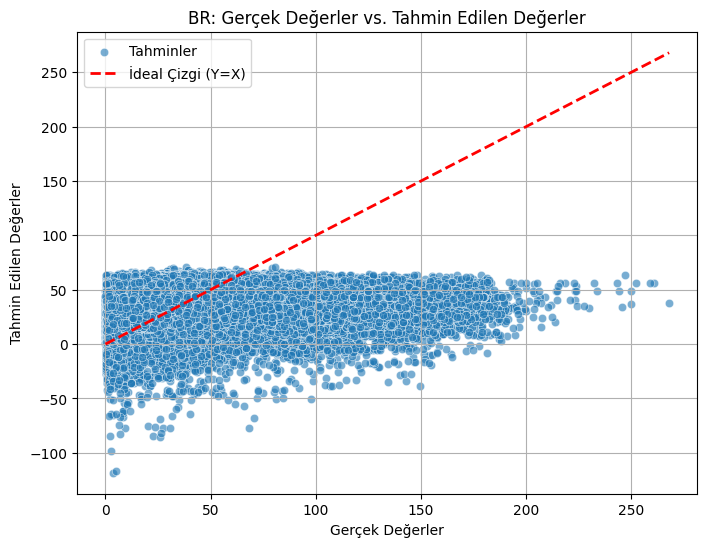

Modeller Eğitiliyor:  50%|███████████████████████████████                               | 1/2 [02:32<02:32, 152.19s/it]


--- XGB Modeli İşleniyor ---


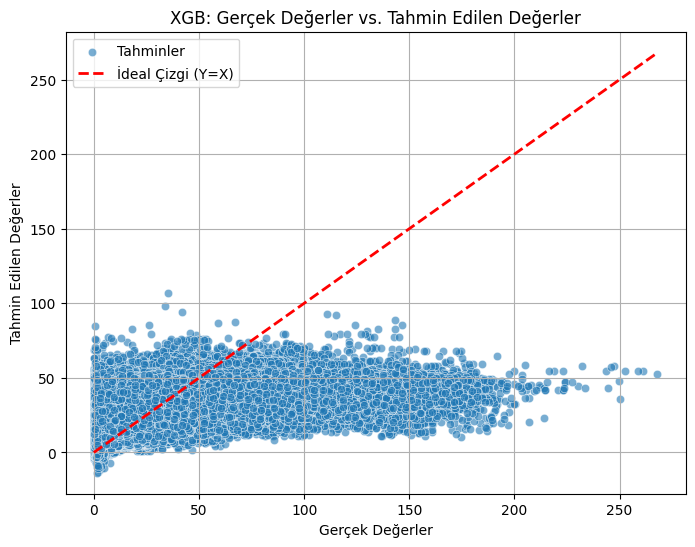

Modeller Eğitiliyor: 100%|██████████████████████████████████████████████████████████████| 2/2 [06:32<00:00, 196.49s/it]



             REGRESYON MODELLERİ SONUÇLARI
+-------+-------------------+--------------------+--------------------+--------------------+----------------------+---------------------+-------------------+---------------------+
| Model |        MAE        |        MSE         |        RMSE        |     Precision      |        Recall        |    F-0.05 Score     |  Train Time (s)   |    Test Time (s)    |
+-------+-------------------+--------------------+--------------------+--------------------+----------------------+---------------------+-------------------+---------------------+
|  XGB  | 7.001571413546437 | 159.4047701021213  | 12.625560189635994 | 0.7882620276034197 | 0.14304642476889018  | 0.7794941128188263  | 107.0514760017395 | 1.0086970329284668  |
|  BR   | 9.442233489610539 | 214.96438233215886 | 14.661663695916602 | 0.2619551417689378 | 0.004184482263270859 | 0.22707232230458022 | 7.325041055679321 | 0.12299656867980957 |
+-------+-------------------+--------------------+-----

In [3]:
#!/usr/bin/env python
# coding: utf-8

import warnings
warnings.filterwarnings("ignore")

import os
import time
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tabulate import tabulate

# Scikit-learn kütüphanelerinden gerekli modülleri içe aktarma
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, fbeta_score

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Derin Öğrenme (ANN) için TensorFlow ve Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# ## Yardımcı Fonksiyonlar ve Ayarlar

def create_folder(f_name):
    """Belirtilen isimde bir klasör oluşturur, eğer mevcut değilse."""
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print(f"Hata: '{f_name}' klasörü oluşturulamadı!")

def build_ann_model(input_shape):
    """Sıralı bir Keras modeli (ANN) oluşturur ve döndürür."""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Çıktı katmanı (regresyon için tek bir nöron)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
    return model

# Gerekli klasörleri oluştur
create_folder("regression_models")
create_folder("regression_results")
create_folder("regression_predictions")

# Mevcut kodu silin veya yorum satırı yapın:
# from sklearn.datasets import make_regression
# X, y = make_regression(n_samples=2000, n_features=20, noise=25, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Yerine kendi kodunuzu ekleyin:
train_df = pd.read_csv('0.15-Train-merged_output.csv')
test_df = pd.read_csv('1-Test-merged_output.csv')

# 'Label' sütununun hedef değişken olduğunu varsayalım
X_train = train_df.drop('real', axis=1)
y_train = train_df['real']
X_test = test_df.drop('real', axis=1)
y_test = test_df['real']


print(f"Eğitim veri seti boyutu: {X_train.shape}")
print(f"Test veri seti boyutu: {X_test.shape}")
print("-" * 30)


# ## Model Tanımlamaları ve Yapılandırma

# Kullanılacak ML algoritmaları
models = {

    #"DTR": DecisionTreeRegressor(random_state=42),
    "BR": BayesianRidge(),
    "XGB": xgb.XGBRegressor( )
   # "KNN": KNeighborsRegressor(),
      #  "LR": LinearRegression(),
}

# Değerlendirme metrikleri için ayarlar
CLASSIFICATION_THRESHOLD = 4.0 # Sınıflandırma metriği için eşik değeri (metre)
FBETA_BETA = 0.05             # F-beta skoru için beta değeri (presizyona ağırlık verir)

# Sonuçları saklamak için bir liste
results_list = []


# ## Model Eğitimi, Değerlendirmesi ve Kaydedilmesi

for model_name, model in tqdm(models.items(), desc="Modeller Eğitiliyor"):
    print(f"\n--- {model_name} Modeli İşleniyor ---")

    # ----- Eğitim -----
    start_time = time.time()
    if model_name == "ANN":
        # ANN için EarlyStopping callback'i
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_train, y_train,
                  epochs=100,
                  batch_size=32,
                  validation_split=0.1,
                  callbacks=[early_stopping],
                  verbose=0) # Eğitim sürecini konsola yazdırmaz
    else:
        model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # ----- Tahmin -----
    start_time = time.time()
    y_pred = model.predict(X_test).flatten() if model_name == "ANN" else model.predict(X_test)
    test_time = time.time() - start_time

    # ----- Regresyon Metrikleri -----
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # ----- Sınıflandırma Metrikleri (Dönüştürülmüş) -----
    # Gerçek ve tahmin edilen değerleri eşik değerine göre ikili (binary) hale getir
    y_test_binary = (np.abs(y_test) <= CLASSIFICATION_THRESHOLD).astype(int)
    y_pred_binary = (np.abs(y_pred) <= CLASSIFICATION_THRESHOLD).astype(int)

    precision = precision_score(y_test_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_test_binary, y_pred_binary, zero_division=0)
    fbeta = fbeta_score(y_test_binary, y_pred_binary, beta=FBETA_BETA, zero_division=0)

    # Sonuçları listeye ekle
    results_list.append({
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "Precision": precision,
        "Recall": recall,
        f"F-{FBETA_BETA} Score": fbeta,
        "Train Time (s)": train_time,
        "Test Time (s)": test_time
    })

    # ----- Modeli Kaydetme -----
    if model_name == "ANN":
        model.save(f"regression_models/{model_name}_model.h5")
    else:
        with open(f"regression_models/{model_name}_model.pkl", "wb") as f:
            pickle.dump(model, f)

    # ----- Tahminleri Kaydetme ve Görselleştirme -----
    predictions_df = pd.DataFrame({'real': y_test, 'estimated': y_pred})
    predictions_df.to_csv(f"regression_predictions/{model_name}_predictions.csv", index=False)

    # Gerçek vs. Tahmin Grafiği (Yaratıcı Eklenti)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label="Tahminler")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label="İdeal Çizgi (Y=X)")
    plt.title(f'{model_name}: Gerçek Değerler vs. Tahmin Edilen Değerler')
    plt.xlabel('Gerçek Değerler')
    plt.ylabel('Tahmin Edilen Değerler')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"regression_results/{model_name}_gercek_vs_tahmin.pdf", bbox_inches='tight')
    plt.show()


# ## Sonuçların Raporlanması

# Sonuçları bir DataFrame'e dönüştür
results_df = pd.DataFrame(results_list)

# Sonuçları RMSE'ye göre sırala
results_df = results_df.sort_values(by="RMSE", ascending=True).reset_index(drop=True)

# Sonuçları ekrana ve dosyaya yazdır
print("\n\n" + "="*50)
print("             REGRESYON MODELLERİ SONUÇLARI")
print("="*50)

# Tabulate ile güzel bir tablo formatında göster
print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))

# Sonuçları CSV dosyasına kaydet
results_df.to_csv("regression_results/tum_modeller_sonuclari1.csv", index=False)

print("\n\nAnaliz tamamlandı. Tüm modeller, tahminler ve sonuçlar ilgili klasörlere kaydedildi. ✅")

Eğitim veri seti boyutu: (16478389, 9)
Test veri seti boyutu: (67588605, 9)
------------------------------


Modeller Eğitiliyor:   0%|                                                                       | 0/1 [00:00<?, ?it/s]


--- XGB Modeli İşleniyor ---


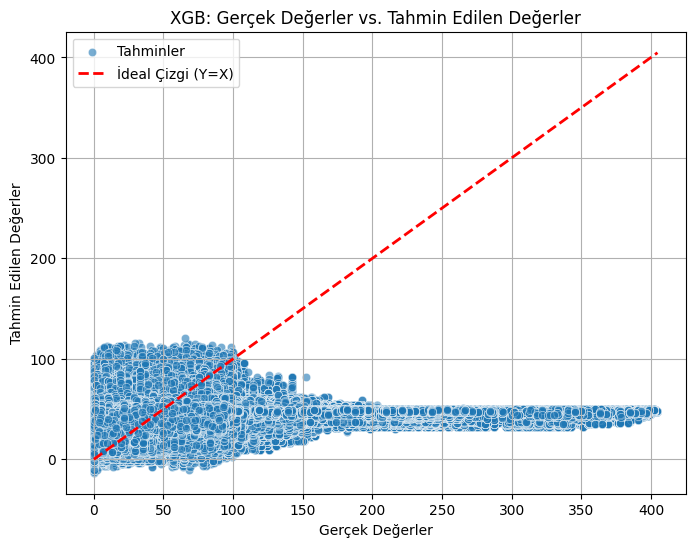

Modeller Eğitiliyor: 100%|███████████████████████████████████████████████████████████| 1/1 [1:22:22<00:00, 4942.26s/it]




             REGRESYON MODELLERİ SONUÇLARI
+-------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+-------------------+
| Model |        MAE        |        MSE         |       RMSE        |      Precision      |        Recall        |    F-0.05 Score     |   Train Time (s)   |   Test Time (s)   |
+-------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+-------------------+
|  XGB  | 35.74422569656582 | 3448.2236824680067 | 58.72157765649699 | 0.22350028680976963 | 0.008943348724156345 | 0.21088372309771863 | 121.68386435508728 | 32.07744359970093 |
+-------+-------------------+--------------------+-------------------+---------------------+----------------------+---------------------+--------------------+-------------------+


Analiz tamamlandı. Tüm modeller, tahminler ve sonuçlar ilg

Modeller Eğitiliyor:   0%|                                                                       | 0/1 [00:00<?, ?it/s]


--- XGB Modeli İşleniyor ---


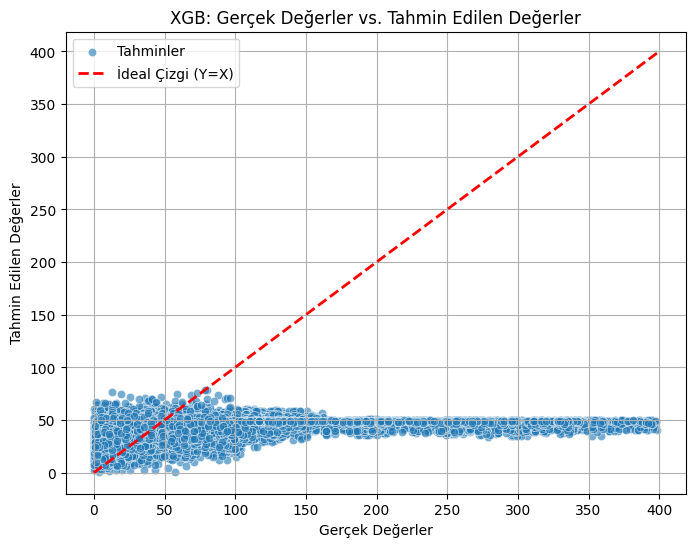

Modeller Eğitiliyor: 100%|██████████████████████████████████████████████████████████████| 1/1 [03:37<00:00, 217.02s/it]



             REGRESYON MODELLERİ SONUÇLARI
+-------+--------------------+--------------------+--------------------+--------------------+-----------------------+---------------------+--------------------+---------------------+
| Model |        MAE         |        MSE         |        RMSE        |     Precision      |        Recall         |    F-0.05 Score     |   Train Time (s)   |    Test Time (s)    |
+-------+--------------------+--------------------+--------------------+--------------------+-----------------------+---------------------+--------------------+---------------------+
|  XGB  | 27.944365728117933 | 2134.3651184293835 | 46.199189586283694 | 0.3333333333333333 | 0.0006174745291756715 | 0.14222379854584144 | 200.50693011283875 | 0.33601903915405273 |
+-------+--------------------+--------------------+--------------------+--------------------+-----------------------+---------------------+--------------------+---------------------+


Analiz tamamlandı. Tüm modeller, tahmi

In [3]:
#!/usr/bin/env python
# coding: utf-8

import warnings
warnings.filterwarnings("ignore")

import os
import time
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tabulate import tabulate

# Scikit-learn kütüphanelerinden gerekli modülleri içe aktarma
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, fbeta_score

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Derin Öğrenme (ANN) için TensorFlow ve Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# ## Yardımcı Fonksiyonlar ve Ayarlar

def create_folder(f_name):
    """Belirtilen isimde bir klasör oluşturur, eğer mevcut değilse."""
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print(f"Hata: '{f_name}' klasörü oluşturulamadı!")

def build_ann_model(input_shape):
    """Sıralı bir Keras modeli (ANN) oluşturur ve döndürür."""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Çıktı katmanı (regresyon için tek bir nöron)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
    return model

# Gerekli klasörleri oluştur
create_folder("regression_models")
create_folder("regression_results")
create_folder("regression_predictions")

# Mevcut kodu silin veya yorum satırı yapın:
# from sklearn.datasets import make_regression
# X, y = make_regression(n_samples=2000, n_features=20, noise=25, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


files=["data/4/trainingData._rss-distance.csv","data/4/validationData._rss-distance.csv"]
for file in files:
    # Yerine kendi kodunuzu ekleyin:
    train_df = pd.read_csv('0.15-Train-merged_output.csv')
    test_df = pd.read_csv(file)
    
    # 'Label' sütununun hedef değişken olduğunu varsayalım
    X_train = train_df.drop('real', axis=1)
    y_train = train_df['real']
    X_test = test_df.drop('real', axis=1)
    y_test = test_df['real']
    
    
    print(f"Eğitim veri seti boyutu: {X_train.shape}")
    print(f"Test veri seti boyutu: {X_test.shape}")
    print("-" * 30)
    
    
    # ## Model Tanımlamaları ve Yapılandırma
    
    # Kullanılacak ML algoritmaları
    models = {
    
        #"DTR": DecisionTreeRegressor(random_state=42),
        #"BR": BayesianRidge(),
        "XGB": xgb.XGBRegressor(random_state=42 )
       # "KNN": KNeighborsRegressor(),
          #  "LR": LinearRegression(),
    }
    
    # Değerlendirme metrikleri için ayarlar
    CLASSIFICATION_THRESHOLD = 4.0 # Sınıflandırma metriği için eşik değeri (metre)
    FBETA_BETA = 0.05             # F-beta skoru için beta değeri (presizyona ağırlık verir)
    
    # Sonuçları saklamak için bir liste
    results_list = []
    
    
    # ## Model Eğitimi, Değerlendirmesi ve Kaydedilmesi
    
    for model_name, model in tqdm(models.items(), desc="Modeller Eğitiliyor"):
        print(f"\n--- {model_name} Modeli İşleniyor ---")
    
        # ----- Eğitim -----
        start_time = time.time()
        if model_name == "ANN":
            # ANN için EarlyStopping callback'i
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=32,
                      validation_split=0.1,
                      callbacks=[early_stopping],
                      verbose=0) # Eğitim sürecini konsola yazdırmaz
        else:
            model.fit(X_train, y_train)
        train_time = time.time() - start_time
    
        # ----- Tahmin -----
        start_time = time.time()
        y_pred = model.predict(X_test).flatten() if model_name == "ANN" else model.predict(X_test)
        test_time = time.time() - start_time
    
        # ----- Regresyon Metrikleri -----
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
    
        # ----- Sınıflandırma Metrikleri (Dönüştürülmüş) -----
        # Gerçek ve tahmin edilen değerleri eşik değerine göre ikili (binary) hale getir
        y_test_binary = (np.abs(y_test) <= CLASSIFICATION_THRESHOLD).astype(int)
        y_pred_binary = (np.abs(y_pred) <= CLASSIFICATION_THRESHOLD).astype(int)
    
        precision = precision_score(y_test_binary, y_pred_binary, zero_division=0)
        recall = recall_score(y_test_binary, y_pred_binary, zero_division=0)
        fbeta = fbeta_score(y_test_binary, y_pred_binary, beta=FBETA_BETA, zero_division=0)
    
        # Sonuçları listeye ekle
        results_list.append({
            "Model": model_name,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "Precision": precision,
            "Recall": recall,
            f"F-{FBETA_BETA} Score": fbeta,
            "Train Time (s)": train_time,
            "Test Time (s)": test_time
        })
    
        # ----- Modeli Kaydetme -----
        if model_name == "ANN":
            model.save(f"regression_models/{model_name}_model.h5")
        else:
            with open(f"regression_models/{model_name}_model.pkl", "wb") as f:
                pickle.dump(model, f)
    
        # ----- Tahminleri Kaydetme ve Görselleştirme -----
        predictions_df = pd.DataFrame({'real': y_test, 'estimated': y_pred})
        predictions_df.to_csv(f"regression_predictions/{file[7:-18]}_predictions.csv", index=False)
    
        # Gerçek vs. Tahmin Grafiği (Yaratıcı Eklenti)
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label="Tahminler")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label="İdeal Çizgi (Y=X)")
        plt.title(f'{model_name}: Gerçek Değerler vs. Tahmin Edilen Değerler')
        plt.xlabel('Gerçek Değerler')
        plt.ylabel('Tahmin Edilen Değerler')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"regression_results/{model_name}_gercek_vs_tahmin.pdf", bbox_inches='tight')
        plt.show()
    
    
    # ## Sonuçların Raporlanması
    
    # Sonuçları bir DataFrame'e dönüştür
    results_df = pd.DataFrame(results_list)
    
    # Sonuçları RMSE'ye göre sırala
    results_df = results_df.sort_values(by="RMSE", ascending=True).reset_index(drop=True)
    
    # Sonuçları ekrana ve dosyaya yazdır
    print("\n\n" + "="*50)
    print("             REGRESYON MODELLERİ SONUÇLARI")
    print("="*50)
    
    # Tabulate ile güzel bir tablo formatında göster
    print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))
    
    # Sonuçları CSV dosyasına kaydet
    results_df.to_csv("regression_results/tum_modeller_sonuclari1.csv", index=False)
    
    print("\n\nAnaliz tamamlandı. Tüm modeller, tahminler ve sonuçlar ilgili klasörlere kaydedildi. ✅")

# Huawei task2

Eğitim veri seti boyutu: (16478389, 9)
Test veri seti boyutu: (1944671, 9)
------------------------------


Modeller Eğitiliyor:   0%|                                                                       | 0/2 [00:00<?, ?it/s]


--- BR Modeli İşleniyor ---


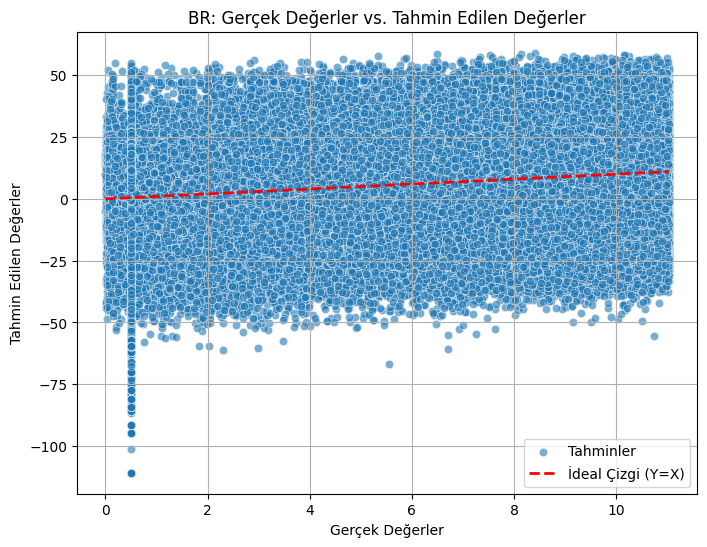

Modeller Eğitiliyor:  50%|███████████████████████████████                               | 1/2 [03:00<03:00, 180.15s/it]


--- XGB Modeli İşleniyor ---


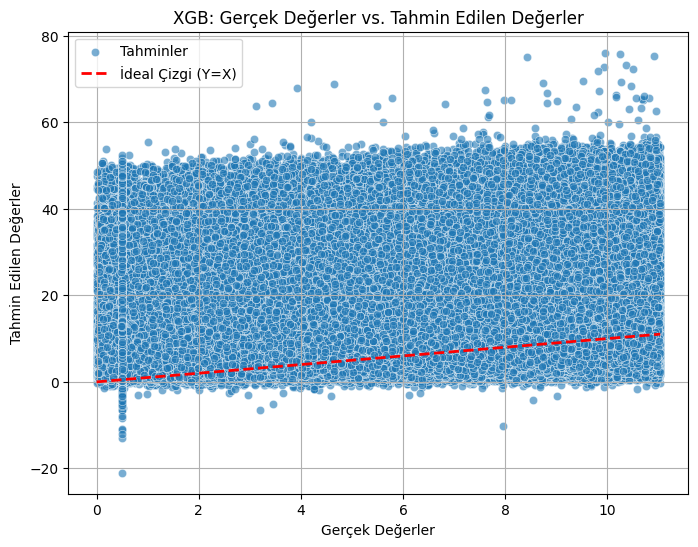

Modeller Eğitiliyor: 100%|██████████████████████████████████████████████████████████████| 2/2 [07:05<00:00, 212.66s/it]



             REGRESYON MODELLERİ SONUÇLARI
+-------+-------------------+-------------------+--------------------+---------------------+---------------------+---------------------+--------------------+---------------------+
| Model |        MAE        |        MSE        |        RMSE        |      Precision      |       Recall        |    F-0.05 Score     |   Train Time (s)   |    Test Time (s)    |
+-------+-------------------+-------------------+--------------------+---------------------+---------------------+---------------------+--------------------+---------------------+
|  XGB  | 6.013345496005595 | 90.55466428695883 | 9.516021452632335  | 0.2699239158683359  | 0.17606827614426843 | 0.2695655725466328  | 106.22458481788635 | 0.9766457080841064  |
|  BR   | 9.717745974350358 | 147.9633786630844 | 12.164019839801496 | 0.05830892991492563 | 0.14723797275968903 | 0.05839688665200787 | 8.042655944824219  | 0.10244870185852051 |
+-------+-------------------+-------------------+------

In [5]:
#!/usr/bin/env python
# coding: utf-8

import warnings
warnings.filterwarnings("ignore")

import os
import time
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tabulate import tabulate

# Scikit-learn kütüphanelerinden gerekli modülleri içe aktarma
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, fbeta_score

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Derin Öğrenme (ANN) için TensorFlow ve Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# ## Yardımcı Fonksiyonlar ve Ayarlar

def create_folder(f_name):
    """Belirtilen isimde bir klasör oluşturur, eğer mevcut değilse."""
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print(f"Hata: '{f_name}' klasörü oluşturulamadı!")

def build_ann_model(input_shape):
    """Sıralı bir Keras modeli (ANN) oluşturur ve döndürür."""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Çıktı katmanı (regresyon için tek bir nöron)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
    return model

# Gerekli klasörleri oluştur
create_folder("regression_models")
create_folder("regression_results")
create_folder("regression_predictions")

# Mevcut kodu silin veya yorum satırı yapın:
# from sklearn.datasets import make_regression
# X, y = make_regression(n_samples=2000, n_features=20, noise=25, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    
files=["./data/task2_data/train/task2_train_estimated_wifi_distances-distance.csv"]
for file in files:
    # Yerine kendi kodunuzu ekleyin:
    train_df = pd.read_csv('0.15-Train-merged_output.csv')
    test_df = pd.read_csv(file)
    
    # 'Label' sütununun hedef değişken olduğunu varsayalım
    X_train = train_df.drop('real', axis=1)
    y_train = train_df['real']
    X_test = test_df.drop('real', axis=1)
    y_test = test_df['real']
    
    
    print(f"Eğitim veri seti boyutu: {X_train.shape}")
    print(f"Test veri seti boyutu: {X_test.shape}")
    print("-" * 30)
    
    
    # ## Model Tanımlamaları ve Yapılandırma
    
    # Kullanılacak ML algoritmaları
    models = {
    
        #"DTR": DecisionTreeRegressor(random_state=42),
        "BR": BayesianRidge(),
        "XGB": xgb.XGBRegressor(random_state=42 )
       # "KNN": KNeighborsRegressor(),
          #  "LR": LinearRegression(),
    }
    
    # Değerlendirme metrikleri için ayarlar
    CLASSIFICATION_THRESHOLD = 4.0 # Sınıflandırma metriği için eşik değeri (metre)
    FBETA_BETA = 0.05             # F-beta skoru için beta değeri (presizyona ağırlık verir)
    
    # Sonuçları saklamak için bir liste
    results_list = []
    
    
    # ## Model Eğitimi, Değerlendirmesi ve Kaydedilmesi
    
    for model_name, model in tqdm(models.items(), desc="Modeller Eğitiliyor"):
        print(f"\n--- {model_name} Modeli İşleniyor ---")
    
        # ----- Eğitim -----
        start_time = time.time()
        if model_name == "ANN":
            # ANN için EarlyStopping callback'i
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=32,
                      validation_split=0.1,
                      callbacks=[early_stopping],
                      verbose=0) # Eğitim sürecini konsola yazdırmaz
        else:
            model.fit(X_train, y_train)
        train_time = time.time() - start_time
    
        # ----- Tahmin -----
        start_time = time.time()
        y_pred = model.predict(X_test).flatten() if model_name == "ANN" else model.predict(X_test)
        test_time = time.time() - start_time
    
        # ----- Regresyon Metrikleri -----
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
    
        # ----- Sınıflandırma Metrikleri (Dönüştürülmüş) -----
        # Gerçek ve tahmin edilen değerleri eşik değerine göre ikili (binary) hale getir
        y_test_binary = (np.abs(y_test) <= CLASSIFICATION_THRESHOLD).astype(int)
        y_pred_binary = (np.abs(y_pred) <= CLASSIFICATION_THRESHOLD).astype(int)
    
        precision = precision_score(y_test_binary, y_pred_binary, zero_division=0)
        recall = recall_score(y_test_binary, y_pred_binary, zero_division=0)
        fbeta = fbeta_score(y_test_binary, y_pred_binary, beta=FBETA_BETA, zero_division=0)
    
        # Sonuçları listeye ekle
        results_list.append({
            "Model": model_name,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "Precision": precision,
            "Recall": recall,
            f"F-{FBETA_BETA} Score": fbeta,
            "Train Time (s)": train_time,
            "Test Time (s)": test_time
        })
    
        # ----- Modeli Kaydetme -----
        if model_name == "ANN":
            model.save(f"regression_models/{model_name}_model.h5")
        else:
            with open(f"regression_models/{model_name}_model.pkl", "wb") as f:
                pickle.dump(model, f)
    
        # ----- Tahminleri Kaydetme ve Görselleştirme -----
        predictions_df = pd.DataFrame({'real': y_test, 'estimated': y_pred})
        predictions_df.to_csv(f"regression_predictions/{file[24:-4]}_predictions.csv", index=False)
    
        # Gerçek vs. Tahmin Grafiği (Yaratıcı Eklenti)
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label="Tahminler")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label="İdeal Çizgi (Y=X)")
        plt.title(f'{model_name}: Gerçek Değerler vs. Tahmin Edilen Değerler')
        plt.xlabel('Gerçek Değerler')
        plt.ylabel('Tahmin Edilen Değerler')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"regression_results/{model_name}_gercek_vs_tahmin.pdf", bbox_inches='tight')
        plt.show()
    
    
    # ## Sonuçların Raporlanması
    
    # Sonuçları bir DataFrame'e dönüştür
    results_df = pd.DataFrame(results_list)
    
    # Sonuçları RMSE'ye göre sırala
    results_df = results_df.sort_values(by="RMSE", ascending=True).reset_index(drop=True)
    
    # Sonuçları ekrana ve dosyaya yazdır
    print("\n\n" + "="*50)
    print("             REGRESYON MODELLERİ SONUÇLARI")
    print("="*50)
    
    # Tabulate ile güzel bir tablo formatında göster
    print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))
    
    # Sonuçları CSV dosyasına kaydet
    results_df.to_csv("regression_results/tum_modeller_sonuclari1.csv", index=False)
    
    print("\n\nAnaliz tamamlandı. Tüm modeller, tahminler ve sonuçlar ilgili klasörlere kaydedildi. ✅")